In [7]:
import IPython.display as IPd
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
from scipy.io import loadmat
from svgutils.compose import *
import svgutils.transform as sg
import time as time_module

### Cascade fit

In [2]:
# Load the stimuli and data
data_path = "../../../data/RiekeMouseConeResponses.mat"
data = loadmat(data_path)

responses = [data['ConeResponses'][0][i][0][0][0][0] for i in range(6)]
stimuli = [data['ConeResponses'][0][i][0][0][1][0] for i in range(6)]

test_stim = stimuli[4]
test_response = responses[4]

In [3]:
# Load the fits (see the notebook OPL/cascade_fit.ipynb)
with open("cascade_final_fit.pkl", "rb") as f:
    cascade_fit = pickle.load(f)
trained_normed = cascade_fit['trained_normed']
init_normed = cascade_fit['init_normed']

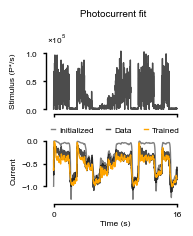

In [4]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, axs = plt.subplots(2, 1, figsize=(1.75, 2.), sharex=True)
    time = np.arange(0, 16, 0.0001)
    axs[0].plot(time, test_stim, color="k", alpha=0.7)
    axs[1].plot(time, init_normed, color="grey", label="Initialized")
    axs[1].plot(time, test_response, color="k", alpha=0.7, label="Data")
    axs[1].plot(time, trained_normed, color="orange", label="Trained")

    axs[0].yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(useMathText=True))
    axs[0].ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
    axs[0].set_ylabel("Stimulus (P*/s)")
    axs[1].set_ylabel("Current")

    # axs[1].legend(loc="upper left", bbox_to_anchor=(0.95, 1.0), handlelength=1.0)
    axs[1].legend(bbox_to_anchor=(0., 1.02, 1.0, .102), loc='lower left', 
                  ncols=3, mode="expand", borderaxespad=0., handlelength=0.5, handletextpad=0.5)
    sns.despine(offset=1)

    axs[0].spines["left"].set_bounds(0, 10**5)
    axs[1].spines["left"].set_bounds(-1, 0)
    axs[0].spines["bottom"].set_bounds(0, 16)
    axs[1].spines["bottom"].set_bounds(0, 16)
    # axs[1].set_xlim(0, 16)
    axs[1].set_xticks([0, 16])
    axs[1].set_xlabel("Time (s)", labelpad=2)

    fig.align_labels()
    plt.subplots_adjust(hspace=0.4)
    fig.suptitle("Photocurrent fit", x=0.5, y=1.075, fontsize=7)

    plt.savefig("../svgs/panel_a.svg", transparent=True)
    plt.show()

### Glutamate fit

In [14]:
# Load the data
with open("../../../data/120_center_responses.pkl", "rb") as f:
    trace_selection = pickle.load(f) 

# Load the cell numbers
with open("../../../params/ribbon/cell_nums.txt", "r") as f:
    cell_nums = json.load(f)

# Load the final solutions
with open("ribbon_solns.pkl", "rb") as f:
    final_solns = pickle.load(f)

In [15]:
n2show = 5

# Choose a random subset from the best 20 selection that are used for mnist
with open("../../../params/ribbon/best_20_params_w_cellnums.pkl", "rb") as f:
    best_cell_nums, best_params = pickle.load(f)
_ = np.random.seed(0)
rand_dorsal = np.random.choice(best_cell_nums[:10], n2show, replace=False)
rand_ventral = np.random.choice(best_cell_nums[10:], n2show, replace=False)
trace_indices = np.concatenate((rand_dorsal, rand_ventral))
trace_indices

array([ 6, 14, 11, 20,  5, 62, 66, 61, 65, 75])

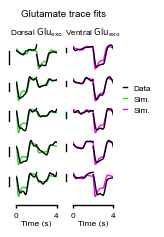

In [16]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, axs = plt.subplots(n2show, 2, figsize=(1.25, 2.))
    nrows, ncols = axs.shape
    colors = ["limegreen"] * n2show + ["magenta"] * n2show

    time = np.arange(0, 4, step=0.025/1000)
    data_time = np.arange(0, 4, step=1/500)

    for i, iin in enumerate(trace_indices):
        axes_row_major = [axs[i//ncols, i%ncols] for i in range(nrows*ncols)]
        ax = axs.flatten(order='F')[i]

        # Plot the simulation results
        soln_idx = list(cell_nums).index(iin) # instead of i if calced all final solns
        ax.plot(data_time, final_solns[soln_idx], c=colors[i])

        ax.spines["left"].set_bounds((-1, 0))
        
        # Plot the data
        # NOTE: trace selections were pre-cut in some cases, but it shouldn't matter
        trace_selection_g = trace_selection[iin, :1000]
        g_time = data_time[:1000]
        trace_selection_uv = trace_selection[iin, 1000:]
        uv_time = data_time[1000:]
        ax.plot(g_time, trace_selection_g, c="k")
        ax.plot(uv_time, trace_selection_uv, c="k")

        # left column
        if i < (n2show - 1):
            sns.despine(ax=ax, offset=5, bottom=True)
            ax.set_xticks([])
            ax.set_yticks([])
        elif i == (n2show - 1):
            sns.despine(ax=ax, offset=5)
            ax.set_yticks([])
        # right column
        elif i > (n2show - 1) and i < (2*n2show - 1):
            sns.despine(ax=ax, offset=5, bottom=True)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            sns.despine(ax=ax, offset=5)
            ax.set_yticks([])

    axs[0, 0].set_title(r"Dorsal $\mathrm{Glu_{exo}}$")
    axs[0, 1].set_title(r"Ventral $\mathrm{Glu_{exo}}$")

    plt.setp(axs, xlim=(0, 4))
    axs[-1, 0].set_xticks([0, 4])
    axs[-1, 1].set_xticks([0, 4])
    axs[-1, 0].set_xlabel("Time (s)", labelpad=2)
    axs[-1, 1].set_xlabel("Time (s)", labelpad=2)

    # Make a legend
    custom_lines = [mpl.lines.Line2D([0], [0], color="k"),
                    mpl.lines.Line2D([0], [0], color="limegreen"),
                    mpl.lines.Line2D([0], [0], color="magenta")]
    axs[-3, 1].legend(
        custom_lines, 
        ['Data', 'Sim.', 'Sim.'], 
        loc="lower left",
        bbox_to_anchor=(1.05, 0.5),
        handlelength=0.5
        )
    plt.subplots_adjust(wspace=0.4)
    
    fig.suptitle("Glutamate trace fits", x=0.5, y=1.05, fontsize=7)

    plt.savefig("../svgs/panel_b.svg", transparent=True)
    plt.show()


### Ribbon parameter dists

In [17]:
# Load the kdes from results
with open("ribbon_kde.pkl", "rb") as f:
    kde_data = pickle.load(f)

In [18]:
# For generating tick labels
round_to_n = lambda x, n: x if x == 0 else round(x, -int(np.floor(np.log10(abs(x)))) + (n - 1))

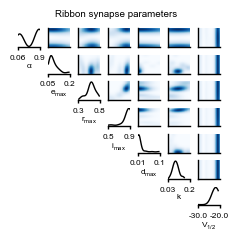

In [20]:
# Pair plots
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, axs = plt.subplots(7, 7, figsize=(2.6, 2.3))

    p_names_pretty = [r"$\alpha$", r"$e_{max}$", r"$r_{max}$", r"$i_{max}$", r"$d_{max}$", "k", r"$V_{1/2}$"]

    for i, key in enumerate(kde_data["xxs"]):
        for j, key2 in enumerate(kde_data["xxs"]):
            if j > i:
                xx = kde_data["xxs"][key][key2]
                yy = kde_data["yys"][key][key2]
                z = kde_data["zs"][key][key2]

                # Produce the image
                contour = axs[i, j].pcolormesh(xx, yy, z, cmap='Blues')
                
                # Plot formatting
                xmin, xmax = xx.min(), xx.max()
                ymin, ymax = yy.min(), yy.max()
                axs[i, j].set_aspect('auto')   
                axs[i, j].set_xlim([xmin, xmax])
                axs[i, j].set_ylim([ymin, ymax])
                axs[i, j].set_xticks([])
                axs[i, j].set_yticks([])
                sns.despine(ax=axs[i, j]) 

            elif i == j:
                # Add the 1D marginals (1d KDE)
                xx = kde_data["xxs"][key][key2]
                z = kde_data["zs"][key][key2]

                axs[i, j].plot(xx, z, c='k')
                
                xmin, xmax = xx.min(), xx.max()
                xmin = round_to_n(xmin, 1)
                xmax = round_to_n(xmax, 1)
                axs[i, j].set_xlabel(p_names_pretty[i], labelpad=1.0)
                axs[i, j].set_xlim([xmin, xmax])
                axs[i, j].set_xticks([xmin, xmax], [round(xmin, 2), round(xmax, 2)])
                axs[i, j].set_yticks([])
                sns.despine(ax=axs[i, j], left=True)

            else:
                sns.despine(ax=axs[i, j], left=True, bottom=True)
                axs[i, j].set_xticks([])
                axs[i, j].set_yticks([])
                axs[i, j].patch.set_alpha(0.0)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    fig.suptitle("Ribbon synapse parameters", x=0.5, y=0.96, fontsize=7)   
     
    plt.savefig("../svgs/panel_c.svg", transparent=True)
    plt.show()

### Spectral contrast/selectivity comparison

In [21]:
with open("SC_comps.pkl", "rb") as f:
    SC_comp = pickle.load(f)

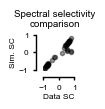

In [22]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, axs = plt.subplots(figsize=(0.75, 0.75), layout="constrained")
    axs.scatter(SC_comp["data_SCs"], SC_comp["sim_SCs"], c="k", alpha=0.4)
    axs.set_xlabel("Data SC", labelpad=2)
    axs.set_ylabel("Sim. SC", labelpad=2)
    axs.spines["bottom"].set_bounds([-1, 1])
    axs.spines["left"].set_bounds([-1, 1])
    axs.set_xticks([-1, 0, 1])
    axs.set_yticks([-1, 0, 1])
    sns.despine(offset=5)

    fig.suptitle("Spectral selectivity\ncomparison", x=0.65, y=1.25, fontsize=7)

    plt.savefig("../svgs/panel_d.svg", transparent=True)
    plt.show()

### Full figure

In [23]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time_module.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}

f = Figure("14cm", "6cm",
    Panel(
          SVG("../svgs/panel_a.svg").scale(svg_scale),
          Text("a", 5, 15, **kwargs_text),
    ).move(0, 0),
    
    Panel(
          SVG("../svgs/panel_b.svg").scale(svg_scale),
          Text("b", -10, 15, **kwargs_text),
    ).move(180, 0),

    Panel(
          SVG("../svgs/panel_c.svg").scale(svg_scale),
          Text("c", -10, 15, **kwargs_text),
    ).move(320, 0),

    Panel(
          SVG("../svgs/panel_d.svg").scale(svg_scale),
          Text("d", -5, 15, **kwargs_text),
    ).move(315, 118)
)

# !mkdir -p fig
f.save("../fig/fig2.svg")
svg("../fig/fig2.svg")